<a href="https://colab.research.google.com/github/wihika/INF0619/blob/main/INF0619_Classificacao_de_revisoes_de_filmes_weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabalho Final — INF-0619 Classificação de Revisões de Filmes  
Alunos:



#Descrição
O site Rotten Tomatoes é uma plataforma amplamente reconhecida que coleta e exibe avaliações de filmes feitas tanto
por usuários comuns, referidos como audiência, quanto por críticos especializados em cinema, o que proporciona
uma visão abrangente sobre a recepção de um filme. Uma tarefa crítica que surge desse conjunto de dados é a
classificação das avaliações, que pode ser realizada de diferentes maneiras, incluindo a análise do sentimento, que
identifica opiniões expressas nas críticas como positivas, negativas ou neutras, e a atribuição de notas, que facilita
a comparação entre diferentes filmes. Realizar essas análises de forma automática é de grande importância, pois
permite processar uma quantidade significativa de dados de maneira eficiente e precisa, ajudando os usuários a
fazer escolhas informadas sobre quais filmes assistir e fornecendo insights valiosos sobre tendências de recepção
cinematográfica ao longo do tempo.
A base de dados deste projeto contém avaliações de usuários, com notas variando entre 0.5 e 5, de 0.5 em 0.5, e
avaliações de críticos de cinema, com o sentimento associado (positivo ou negativo).

#Objetivo Principal
Este projeto envolve dois problemas, sendo uma tarefa binária e uma tarefa multi-classe, cujo objetivo é predizer
corretamente o sentimento da avaliação do crítico (classificação binária) e a nota de avaliação do usuário (multiclasse) baseado no texto da avaliação. A métrica que deverá ser utilizada neste projeto é a Acurácia Balanceada.

#Técnicas Envolvidas
*   Processamento de linguagem natural;
*   Processamento e representação de dados textuais;
*   Classificação binária;
*   Classificação multi-classe.

#Desafios
*   Para esse projeto, alguns desafios são:
*   Explorar técnicas de processamento de linguagem natural;
*   Analisar as palavras e termos-chaves de cada classe;
*   Lidar com o desbalanceamento de classes;
*   Classificar corretamente o sentimento das revisões dos críticos;
*   Classificar corretamente a nota da avaliação dos usuários.

#Conjunto de Dados
*   Kaggle da base de dados (https://www.kaggle.com/datasets/coltonbarger/rotten-tomatoes-reviews-for-online-streaming-shows/data);
*   Conjunto de dados (https://drive.google.com/drive/folders/10wfbJmPUqfZNs3HY4_Y_Uw1Ef0hFMRU5).


## Instalação das Bibliotecas

Instalar as bibliotecas necessárias:

In [3]:
!pip install pandas
!pip install transformers
!pip install bertviz
!pip install datasets

Chamada das bibliotecas necessárias:

In [4]:
import pandas
import numpy
import torch
import seaborn
import matplotlib.pyplot as plot
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from bertviz import model_view, head_view

## Carregar e preparar os dados

**critic_reviews**
- **Show**: titulo do show avaliado
- **Sentiment**: Sentimento sendo 0 negativo e 1 positivo (2 classes)
- **Review**: conteúdo da avaliação

In [5]:
critic_df = pandas.read_csv("train_critic.csv", header=0)
test_critic_df = pandas.read_csv("test_critic.csv", header=0)

| **Show**                           | **Review**                                                                                       | **Sentiment** |
|------------------------------------|--------------------------------------------------------------------------------------------------|---------------|
| Bodyguard                          | This has been a brilliant, compulsive, five-star drama...                                        | 1             |
| Mad Men                            | With each new season, I try to remind myself that...                                             | 0             |
| 1971: The Year That Music Changed Everything | Here's one of the most all-encompassing and stunning...                                         | 1             |
| Six Feet Under                     | To me, it was one of the most clever, funny, smart...                                            | 1             |
| Pieces of Her                      | Well acted and highly suspenseful, the eight-part drama...                                       | 0             |
| ...                                | ...                                                                                              | ...           |
| Freaks and Geeks                   | Freaks and Geeks boasts an extremely talented cast...                                            | 1             |
| The Gilded Age                     | It's a period piece set in 1882 New York that captures...                                        | 1             |
| Joe vs Carole                      | McKinnon and her co-producers must be credited for...                                            | 1             |
| Rick and Morty                     | As season openers go, this is a really solid entry...                                            | 1             |
| Y: The Last Man                    | Once the show moves past its been-there, watched-that...                                         | 1             |


**audience_reviews**
- **Show**: titulo do show avaliado
- **Rating**: nota do show de 0 a 5, com steps de 0.5 (10 classes)
- **Review**: conteúdo da avaliação

In [6]:
audience_df = pandas.read_csv("train_audience.csv", header=0)
test_audience_df = pandas.read_csv("test_audience.csv", header=0)

| **Show**                | **Review**                                                                                         | **Rating** |
|--------------------------|---------------------------------------------------------------------------------------------------|------------|
| Game of Thrones          | Lost all guidance without the book. Somehow ruined the entire legacy...                          | 0.5        |
| The Book of Boba Fett    | It felt mostly bizarre. Boba Fett himself seems out of place...                                   | 2.5        |
| Safe                     | It started well and got me hooked, but it gets dull by the end...                                 | 3.0        |
| Midnight Mass            | Here's what you get in this series: Long-winded speeches, some clever moments...                 | 2.0        |
| Star Wars: Visions       | I am a big fan of Star Wars and anime, so I really enjoyed this...                                | 4.5        |
| ...                      | ...                                                                                               | ...        |
| Ozark                    | Don't watch the last season - anticlimactic. Very disappointing...                                | 1.0        |
| Game of Thrones          | I wanted to give this higher for the excellent earlier seasons, but the ending ruins it...        | 1.5        |
| Attack on Titan          | This season will make Attack on Titan a masterpiece in storytelling and animation...              | 5.0        |
| Watchmen                 | Looks terrible. Story is about some sort of random nonsense...                                    | 0.5        |
| Peacemaker               | Fun, exciting, well-written, and enjoyable are the words that come to mind for this series...     | 5.0        |


## Variaveis de configuração


Variaveis gerais

In [7]:
IS_TEST = True  # Variavel para deixar as runs menores para testar o codigo mais rapido
MODEL_NAME = "prajjwal1/bert-tiny"  # Escolha o modelo conforme sua necessidade
NUM_EPOCHS = 10 # Número de épocas
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define como rodar dependendo se houver GPU
MAX_LEN = 256 # Parametro usado no tokenizer

Variaveis Critic

In [8]:
NUM_LABELS_CRITIC = 2 # Número de classes para a base critic
TOKENIZER_CRITIC =  AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC)  # Carregar o tokenizer para o critic
MODEL_CRITIC = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC, output_attentions=False, output_hidden_states=False).to(DEVICE)  # Carregar o modelo de classificação para 2 classes

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Variaveis Audience

In [9]:
NUM_LABELS_AUDIENCE = 10 # Número de classes para a base audience
TOKENIZER_AUDIENCE =  AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE)  # Carregar o tokenizer para o audience
MODEL_AUDIENCE = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE, output_attentions=False, output_hidden_states=False).to(DEVICE)   # Carregar o modelo de classificação para 2 classes

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preparação dos Conjuntos de Dados


Preparação dos dados Critic

In [43]:
critic_df = critic_df.replace([numpy.inf, -numpy.inf], numpy.nan)
critic_df.dropna(inplace=True)
test_critic_df = test_critic_df.replace([numpy.inf, -numpy.inf], numpy.nan)
test_critic_df.dropna(inplace=True)
distinct_sentiment_labels = critic_df.Sentiment.unique()
distinct_sentiment_labels.sort()
distinct_sentiment_label_dict = {}
for index, label in enumerate(distinct_sentiment_labels):
    distinct_sentiment_label_dict[label] = index

critic_df['label'] = critic_df.Sentiment.replace(distinct_sentiment_label_dict)
critic_df.label = critic_df.label.astype(int)
test_critic_df['label'] = test_critic_df.Sentiment.replace(distinct_sentiment_label_dict)
test_critic_df.label = test_critic_df.label.astype(int)

critic_df['Review'] = critic_df['Review'].astype(str)
test_critic_df['Review'] = test_critic_df['Review'].astype(str)

train_critic_data, val_critic_data, train_critic_labels, val_critic_labels = train_test_split(critic_df.index.values,
                                                                                              critic_df.label.values,
                                                                                              test_size=0.2, random_state=42,
                                                                                              stratify=critic_df.label.values)

# balanceando os dados de treino
class_weights_critic = compute_class_weight('balanced', classes=numpy.unique(train_critic_labels), y=train_critic_labels)
class_weight_critic_dict = dict(enumerate(class_weights_critic))

In [11]:
critic_df.label.value_counts()

,count
label,
0,9995
1,1836


In [12]:
 pandas.Series(train_critic_labels).value_counts()

,count
0,7995
1,1469


In [13]:
encoded_critic_data_train = TOKENIZER_CRITIC.batch_encode_plus(
    critic_df.loc[train_critic_data, 'Review'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_critic_data_val = TOKENIZER_CRITIC.batch_encode_plus(
    critic_df.loc[val_critic_data, 'Review'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_critic_data_test = TOKENIZER_CRITIC.batch_encode_plus(
    test_critic_df.Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

input_ids_train_critic = encoded_critic_data_train['input_ids']
input_ids_val_critic = encoded_critic_data_val['input_ids']
input_ids_test_critic = encoded_critic_data_test['input_ids']

attention_mask_train_critic = encoded_critic_data_train['attention_mask']
attention_mask_val_critic = encoded_critic_data_val['attention_mask']
attention_mask_test_critic = encoded_critic_data_test['attention_mask']

labels_train_critic = torch.tensor(critic_df.loc[train_critic_data, 'label'].values)
labels_val_critic = torch.tensor(critic_df.loc[val_critic_data, 'label'].values)
labels_test_critic = torch.tensor(test_critic_df.label.values)

dataset_train_critic = TensorDataset(input_ids_train_critic, attention_mask_train_critic, labels_train_critic)
dataset_val_critic = TensorDataset(input_ids_val_critic, attention_mask_val_critic, labels_val_critic)
dataset_test_critic = TensorDataset(input_ids_test_critic, attention_mask_test_critic, labels_test_critic)

dataloader_train_critic = DataLoader(dataset_train_critic)
dataloader_val_critic = DataLoader(dataset_val_critic)
dataloader_test_critic = DataLoader(dataset_test_critic)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning

Preparação dos dados Audience

In [41]:
audience_df = audience_df.replace([numpy.inf, -numpy.inf], numpy.nan)
audience_df.dropna(inplace=True)
test_audience_df = test_audience_df.replace([numpy.inf, -numpy.inf], numpy.nan)
test_audience_df.dropna(inplace=True)
distinct_rating_labels = audience_df.Rating.unique()
distinct_rating_labels.sort()
distinct_rating_label_dict = {}
for index, label in enumerate(distinct_rating_labels):
    distinct_rating_label_dict[label] = index

audience_df['label'] = audience_df.Rating.replace(distinct_rating_label_dict)
audience_df.label = audience_df.label.astype(int)
test_audience_df['label'] = test_audience_df.Rating.replace(distinct_rating_label_dict)
test_audience_df.label = test_audience_df.label.astype(int)

audience_df['Review'] = audience_df['Review'].astype(str)
test_audience_df['Review'] = test_audience_df['Review'].astype(str)

train_audience_data, val_audience_data, train_audience_labels, val_audience_labels = train_test_split(test_audience_df.index.values,
                                                                                                      test_audience_df.label.values,
                                                                                                      test_size=0.2, random_state=42,
                                                                                                      stratify=test_audience_df.label.values)

# balanceando os dados de treino
class_weights_audience = compute_class_weight('balanced', classes=numpy.unique(train_audience_labels), y=train_audience_labels)
class_weight_audience_dict = dict(enumerate(class_weights_audience))

In [15]:
audience_df.label.value_counts()

,count
label,
5,23642
0,7016
8,3869
4,3792
7,3309
3,2690
6,2340
2,2141
9,2040


In [16]:
 pandas.Series(train_audience_labels).value_counts()

,count
5,4613
0,1439
4,779
8,766
7,707
3,547
6,509
2,430
9,383
1,311


In [17]:
encoded_audience_data_train = TOKENIZER_AUDIENCE.batch_encode_plus(
    audience_df.loc[train_audience_data, 'Review'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_audience_data_val = TOKENIZER_AUDIENCE.batch_encode_plus(
    audience_df.loc[val_audience_data, 'Review'].values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_audience_data_test = TOKENIZER_AUDIENCE.batch_encode_plus(
    test_audience_df.Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

input_ids_train_audience = encoded_audience_data_train['input_ids']
input_ids_val_audience = encoded_audience_data_val['input_ids']
input_ids_test_audience = encoded_audience_data_test['input_ids']

attention_mask_train_audience = encoded_audience_data_train['attention_mask']
attention_mask_val_audience = encoded_audience_data_val['attention_mask']
attention_mask_test_audience = encoded_audience_data_test['attention_mask']


labels_train_audience = torch.tensor(audience_df.loc[train_audience_data, 'label'].values)
labels_val_audience = torch.tensor(audience_df.loc[val_audience_data, 'label'].values)
labels_test_audience = torch.tensor(test_audience_df.label.values)

dataset_train_audience = TensorDataset(input_ids_train_audience, attention_mask_train_audience, labels_train_audience)
dataset_val_audience = TensorDataset(input_ids_val_audience, attention_mask_val_audience, labels_val_audience)
dataset_test_audience = TensorDataset(input_ids_test_audience, attention_mask_test_audience, labels_test_audience)

dataloader_train_audience = DataLoader(dataset_train_audience)
dataloader_val_audience = DataLoader(dataset_val_audience)
dataloader_test_audience = DataLoader(dataset_test_audience)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning

### Funções auxiliares


**Função Test** para testar o modelo, parametros são modelo e o dataloader (inputs, attention masks e labels) usados na avaliação. Retorna o loss, o array com a probabilidade de cada classe possível e os labels verdade usados.

In [18]:
def Test(model, dataloader, device):
    model.eval()

    loss_total = 0
    pred, label = [], []

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
                    'input_ids': batch[0].to(device),
                    'attention_mask': batch[1].to(device),
                    'labels': batch[2].to(device)
                  }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_total = loss_total + loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        pred.append(logits)
        label.append(label_ids)

    average_loss = loss_total/len(dataloader)
    pred = numpy.concatenate(pred, axis=0)
    label = numpy.concatenate(label, axis=0)
    return average_loss, pred, label


**Função Treino** para treinar o modelo, parametros são modelo, nome do modelo, o dataloader de treino (inputs, attention masks e labels), o dataloader de validação, o otimizador, um scheduler (outro tipo de otimizador), numero de épocas e o device (cpu ou gpu) usados no treino. Retorna o modelo treinado.

In [19]:
def Train(model, model_name, dataloader_train, dataloader_val, optimizer, scheduler, num_epochs, device, class_weights):
  train_loss_list = []
  val_loss_list = []
  train_accuracy_list = []
  val_accuracy_list = []
  train_balanced_accuracy_list = []
  val_balanced_accuracy_list = []

  criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

  for epoch in range(1, num_epochs + 1):
      model.train()

      loss_total = 0
      all_preds = []
      all_labels = []

      for batch in dataloader_train:
          model.zero_grad()

          batch = tuple(b.to(device) for b in batch)

          inputs = {
                      'input_ids': batch[0].to(device),
                      'attention_mask': batch[1].to(device),
                      'labels': batch[2].to(device)
                    }
          outputs = model(**inputs)

          loss = criterion(outputs[1], inputs['labels'])
          loss_total = loss_total + loss.item()
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0).to(device)

          optimizer.step()
          scheduler.step()

          _, preds = torch.max(outputs[1], 1)  # Get predicted class labels
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(batch[2].cpu().numpy())

      torch.save(model.state_dict(), f'finetuned_{model_name}_{epoch}.model')
      print(f'Epoca {epoch}')

      loss_avg_train = loss_total/len(dataloader_train)
      train_loss_list.append(loss_avg_train)
      print(f'Traning Loss: {loss_avg_train}')
      val_loss, preds, labels = Test(model, dataloader_val, device)
      val_loss_list.append(val_loss)
      print(f'Validation Loss: {val_loss}')

      train_accuracy = accuracy_score(all_labels, all_preds)
      train_accuracy_list.append(train_accuracy)
      print(f'Train Accuracy: {train_accuracy}')
      preds_array = numpy.argmax(preds, axis=1)
      val_accuracy = accuracy_score(labels, preds_array)
      val_accuracy_list.append(val_accuracy)
      print(f'Validation Accuracy: {val_accuracy}')

      train_balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
      train_balanced_accuracy_list.append(train_balanced_accuracy)
      print(f'Train Balanced Accuracy: {train_balanced_accuracy}')
      val_balanced_accuracy = balanced_accuracy_score(labels, preds_array)
      val_balanced_accuracy_list.append(val_balanced_accuracy)
      print(f'Validation Balanced Accuracy: {val_balanced_accuracy}')

  data = {'train_loss': train_loss_list, 'val_loss': val_loss_list, 'train_accuracy': train_accuracy_list, 'val_accuracy': val_accuracy_list, 'train_balanced_accuracy': train_balanced_accuracy_list, 'val_balanced_accuracy': val_balanced_accuracy_list}
  df = pandas.DataFrame(data)

  return model, df

**Função de Plot da Matriz de Confusão** para analisar o modelo, parametros labels verdade, classes preditas, titulo e lista de possiveis classes. Plota a matriz.

In [30]:
def ConfusionMatrix(labels, preds_array, title, classes_list):
  cm = confusion_matrix(labels, preds_array, labels=classes_list)
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis] * 100

  plot.figure(figsize=(8, 6))
  seaborn.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues", xticklabels=classes_list, yticklabels=classes_list)
  plot.xlabel("Predicted Labels")
  plot.ylabel("True Labels")
  plot.title(title)
  plot.show()

### Treino Modelo

Modelo Critic

In [ ]:
optimizer_critic = AdamW(MODEL_CRITIC.parameters(),
                  lr=1e-5)

num_training_steps = len(dataloader_train_critic) * NUM_EPOCHS

num_warmup_steps = int(0.1 * num_training_steps)

scheduler_critic = get_scheduler(
    "linear",
    optimizer=optimizer_critic,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

MODEL_CRITIC, model_critic_train_results = Train(MODEL_CRITIC, 'CRITIC', dataloader_train_critic, dataloader_val_critic, optimizer_critic, scheduler_critic, NUM_EPOCHS, DEVICE, class_weights_critic)

Epoca 1
Traning Loss: 0.592204531741412
Validation Loss: 0.7047099537673722
Train Accuracy: 0.8069526627218935
Validation Accuracy: 0.8449514152936206
Train Balanced Accuracy: 0.5026155727860886
Validation Balanced Accuracy: 0.5
Epoca 2
Traning Loss: 0.7028513093179722
Validation Loss: 0.7301596574657244
Train Accuracy: 0.8447802197802198
Validation Accuracy: 0.8449514152936206
Train Balanced Accuracy: 0.5
Validation Balanced Accuracy: 0.5
Epoca 3
Traning Loss: 0.7458928956355518
Validation Loss: 0.7662279825362707
Train Accuracy: 0.8447802197802198
Validation Accuracy: 0.8449514152936206
Train Balanced Accuracy: 0.5
Validation Balanced Accuracy: 0.5
Epoca 4
Traning Loss: 0.7327760682344093
Validation Loss: 0.7537077702344822
Train Accuracy: 0.8452028740490279
Validation Accuracy: 0.8491761723700887
Train Balanced Accuracy: 0.50191712740817
Validation Balanced Accuracy: 0.5158487738419618
Epoca 5
Traning Loss: 0.6337698720754652
Validation Loss: 0.7628857434139421
Train Accuracy: 0.859

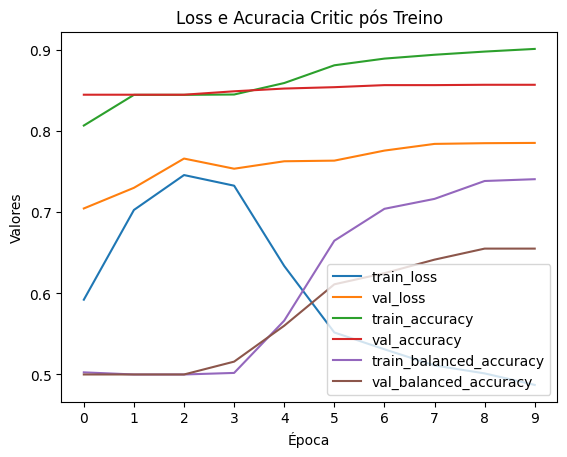

In [ ]:
model_critic_train_results.plot(kind='line')
plot.title('Loss e Acuracia Critic pós Treino')
plot.xticks(range(0, len(model_critic_train_results), 1))
plot.xlabel('Época')
plot.ylabel('Valores')
plot.legend(loc='best')
plot.show()

Evaluation of Training and Validation Results
1. General Observations
Training Loss and Accuracy:

The training loss decreases consistently, indicating the model is learning from the data.
Training accuracy improves steadily from 80.7% (Epoch 1) to 90.1% (Epoch 10), showing a clear trend of better performance on the training set.
Balanced accuracy improves significantly from 50.3% to 74.1% by Epoch 10, suggesting the model is addressing potential class imbalance issues better over time.
Validation Loss and Accuracy:

Validation loss shows less consistent behavior, fluctuating slightly after Epoch 2 but stabilizing around 0.785.
Validation accuracy plateaus at around 85.6%-85.7% after Epoch 6, indicating that the model might have reached its generalization limit or is at risk of overfitting.
Balanced Validation Accuracy:

Shows a steady increase from 50% (Epoch 1) to 65.5% (Epoch 10), indicating that the model is improving its handling of imbalanced class distributions in the validation set.
2. Epoch-by-Epoch Highlights
Epoch 1:

The model begins with a relatively high training loss (0.59) and low balanced accuracy (50%). This suggests initialization is neutral with no clear advantage for class balance.
Validation metrics mirror training, showing the baseline performance.
Epochs 2-3:

Training loss increases slightly (a sign of optimization adjustments like learning rate changes) but stabilizes by Epoch 3.
Validation loss also stabilizes, but balanced accuracy remains stuck at 50%. The model still struggles with class imbalance.
Epoch 4:

Notable improvement in validation balanced accuracy (51.6%). This may be the result of improved model focus on minority class detection.
Epochs 5-7:

Steady improvement in all metrics:
Training loss drops significantly.
Balanced accuracy sees consistent improvement, reaching 70.4% (training) and 62.5% (validation) by Epoch 7.
Epochs 8-10:

Training metrics continue improving:
Loss decreases.
Accuracy surpasses 90% in Epoch 10.
Validation metrics stabilize, with balanced accuracy peaking at 65.5%. This suggests the model generalizes well but may not improve further without additional techniques like data augmentation or hyperparameter tuning.
3. Key Concerns
Overfitting:
By Epoch 6-10, the training accuracy and balanced accuracy are significantly higher than validation. While validation accuracy plateaus, the gap suggests potential overfitting. Consider:
Reducing model complexity.
Applying stronger regularization.
Using early stopping to prevent further divergence.
Validation Plateau:
Validation accuracy plateaus after Epoch 6, which might indicate that the model has reached its capacity for this dataset. To improve:
Introduce more data or augment existing data.
Adjust class weighting to further address imbalance.
Explore different architectures or ensemble methods.

| Época | Treino Loss | Validação Loss | Treino Acurácia | Validação Acurácia | Treino Acurácia Balanceada | Validação Acurácia Balanceada |
|-------|-------------|----------------|------------------|---------------------|----------------------------|-------------------------------|
| 1     | 0.7072      | 0.6993         | 0.5012           | 0.5007              | 0.5014                     | 0.5000                        |
| 2     | 0.7001      | 0.6822         | 0.5080           | 0.5497              | 0.5082                     | 0.5493                        |
| 3     | 0.6796      | 0.6710         | 0.5632           | 0.5769              | 0.5632                     | 0.5773                        |
| 4     | 0.6953      | 1.1087         | 0.6360           | 0.5918              | 0.6360                     | 0.5922                        |
| 5     | 0.9978      | 1.4480         | 0.6793           | 0.6231              | 0.6793                     | 0.6234                        |
| 6     | 1.0355      | 1.4784         | 0.7208           | 0.6490              | 0.7208                     | 0.6492                        |
| 7     | 0.9492      | 1.5060         | 0.7569           | 0.6571              | 0.7569                     | 0.6574                        |
| 8     | 0.8916      | 1.5254         | 0.7838           | 0.6735              | 0.7838                     | 0.6737                        |
| 9     | 0.8183      | 1.5495         | 0.8104           | 0.6816              | 0.8103                     | 0.6818                        |
| 10    | 0.7664      | 1.5677         | 0.8267           | 0.6844              | 0.8267                     | 0.6845                        |
| 11    | 0.7232      | 1.4685         | 0.8407           | 0.7088              | 0.8407                     | 0.7089                        |
| 12    | 0.6697      | 1.5857         | 0.8560           | 0.6966              | 0.8560                     | 0.6967                        |
| 13    | 0.6402      | 1.6149         | 0.8645           | 0.6939              | 0.8645                     | 0.6940                        |
| 14    | 0.5496      | 1.6320         | 0.8880           | 0.6939              | 0.8880                     | 0.6940                        |
| 15    | 0.5590      | 1.7134         | 0.8859           | 0.6939              | 0.8859                     | 0.6940                        |
| 16    | 0.4524      | 1.7934         | 0.9105           | 0.6857              | 0.9104                     | 0.6859                        |
| 17    | 0.4497      | 1.8154         | 0.9105           | 0.6952              | 0.9104                     | 0.6954                        |
| 18    | 0.4377      | 1.8528         | 0.9145           | 0.6966              | 0.9145                     | 0.6968                        |
| 19    | 0.4248      | 1.8596         | 0.9179           | 0.6939              | 0.9179                     | 0.6940                        |
| 20    | 0.4068      | 1.8974         | 0.9227           | 0.6966              | 0.9227                     | 0.6968                        |
| 21    | 0.3879      | 1.8596         | 0.9278           | 0.7034              | 0.9278                     | 0.7035                        |
| 22    | 0.3692      | 1.9001         | 0.9302           | 0.7048              | 0.9302                     | 0.7049                        |
| 23    | 0.3389      | 1.9309         | 0.9336           | 0.7129              | 0.9336                     | 0.7131                        |
| 24    | 0.3178      | 2.0429         | 0.9374           | 0.6871              | 0.9373                     | 0.6873                        |
| 25    | 0.2867      | 2.0153         | 0.9479           | 0.6980              | 0.9479                     | 0.6981                        |
| 26    | 0.2689      | 2.0718         | 0.9520           | 0.6966              | 0.9520                     | 0.6968                        |
| 27    | 0.2876      | 2.0810         | 0.9506           | 0.6993              | 0.9506                     | 0.6995                        |
| 28    | 0.2565      | 2.0449         | 0.9527           | 0.7061              | 0.9527                     | 0.7063                        |
| 29    | 0.2689      | 2.0771         | 0.9510           | 0.7034              | 0.9510                     | 0.7036                        |
| 30    | 0.2439      | 2.0268         | 0.9561           | 0.7224              | 0.9561                     | 0.7226                        |
| 31    | 0.2469      | 2.0382         | 0.9557           | 0.7156              | 0.9557                     | 0.7158                        |
| 32    | 0.2230      | 2.0593         | 0.9605           | 0.7170              | 0.9605                     | 0.7171                        |
| 33    | 0.2595      | 2.0662         | 0.9551           | 0.7116              | 0.9551                     | 0.7117                        |
| 34    | 0.2290      | 2.0728         | 0.9595           | 0.7116              | 0.9595                     | 0.7117                        |
| 35    | 0.2220      | 2.0652         | 0.9629           | 0.7197              | 0.9629                     | 0.7198                        |


Modelo Audience

In [ ]:
optimizer_audience = AdamW(MODEL_AUDIENCE.parameters(),
                  lr=1e-5)

num_training_steps = len(dataloader_train_audience) * NUM_EPOCHS

num_warmup_steps = int(0.1 * num_training_steps)

scheduler_audience = get_scheduler(
    "linear",
    optimizer=optimizer_audience,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

MODEL_AUDIENCE, model_audience_train_results = Train(MODEL_AUDIENCE, 'AUDIENCE', dataloader_train_audience, dataloader_val_audience, optimizer_audience, scheduler_audience, NUM_EPOCHS, DEVICE, class_weights_audience)

Epoca 1
Traning Loss: 2.035478747920629
Validation Loss: 1.7856702205448922
Train Accuracy: 0.3615986264784433
Validation Accuracy: 0.46318199160625717
Train Balanced Accuracy: 0.0960266086083235
Validation Balanced Accuracy: 0.1
Epoca 2
Traning Loss: 1.8077518553902117
Validation Loss: 1.881360596008542
Train Accuracy: 0.4662342617321633
Validation Accuracy: 0.46051125524608927
Train Balanced Accuracy: 0.1417375684185368
Validation Balanced Accuracy: 0.16311000207742515
Epoca 3
Traning Loss: 1.8049326453880095
Validation Loss: 1.8326001074293026
Train Accuracy: 0.5059137733689432
Validation Accuracy: 0.49027088897367416
Train Balanced Accuracy: 0.1753457146904685
Validation Balanced Accuracy: 0.21139717898681817
Epoca 4
Traning Loss: 1.7554339576704987
Validation Loss: 1.7778117597246672
Train Accuracy: 0.5224151087371233
Validation Accuracy: 0.5085845097291111
Train Balanced Accuracy: 0.20557333618576296
Validation Balanced Accuracy: 0.233126344078541
Epoca 5
Traning Loss: 1.70005586

| Epoca | Training Loss | Validation Loss | Train Accuracy | Validation Accuracy | Train Balanced Accuracy | Validation Balanced Accuracy |
|-------|---------------|-----------------|----------------|----------------------|--------------------------|-----------------------------|
| 1     | 2.3076        | 2.2952          | 0.1100         | 0.1170              | 0.1100                  | 0.1171                      |
| 2     | 2.2756        | 2.2313          | 0.1344         | 0.1636              | 0.1343                  | 0.1637                      |
| 3     | 2.1227        | 2.0159          | 0.1994         | 0.2257              | 0.1994                  | 0.2258                      |
| 4     | 1.9660        | 1.9382          | 0.2428         | 0.2438              | 0.2428                  | 0.2439                      |
| 5     | 1.8965        | 1.9425          | 0.2689         | 0.2657              | 0.2689                  | 0.2658                      |
| 6     | 1.8691        | 1.9683          | 0.2845         | 0.2555              | 0.2845                  | 0.2556                      |
| 7     | 1.8491        | 1.9938          | 0.3074         | 0.2670              | 0.3074                  | 0.2671                      |
| 8     | 1.8224        | 2.0254          | 0.3198         | 0.2768              | 0.3198                  | 0.2769                      |
| 9     | 1.7977        | 2.0491          | 0.3387         | 0.2730              | 0.3387                  | 0.2731                      |
| 10    | 1.7690        | 2.0960          | 0.3585         | 0.2663              | 0.3585                  | 0.2664                      |
| 11    | 1.7298        | 2.1217          | 0.3756         | 0.2651              | 0.3755                  | 0.2651                      |
| 12    | 1.7112        | 2.1443          | 0.3897         | 0.2777              | 0.3897                  | 0.2778                      |
| 13    | 1.7004        | 2.1766          | 0.3976         | 0.2730              | 0.3976                  | 0.2731                      |
| 14    | 1.6594        | 2.2213          | 0.4181         | 0.2768              | 0.4181                  | 0.2769                      |
| 15    | 1.6485        | 2.2794          | 0.4216         | 0.2765              | 0.4216                  | 0.2765                      |
| 16    | 1.6385        | 2.3401          | 0.4402         | 0.2708              | 0.4401                  | 0.2708                      |
| 17    | 1.6083        | 2.3982          | 0.4459         | 0.2717              | 0.4458                  | 0.2718                      |
| 18    | 1.5867        | 2.3740          | 0.4595         | 0.2708              | 0.4595                  | 0.2708                      |
| 19    | 1.5657        | 2.4128          | 0.4654         | 0.2628              | 0.4654                  | 0.2629                      |
| 20    | 1.5528        | 2.4242          | 0.4776         | 0.2632              | 0.4776                  | 0.2632                      |
| 21    | 1.5531        | 2.4692          | 0.4757         | 0.2682              | 0.4757                  | 0.2683                      |
| 22    | 1.5250        | 2.4689          | 0.4894         | 0.2676              | 0.4894                  | 0.2676                      |
| 23    | 1.5018        | 2.5186          | 0.4937         | 0.2746              | 0.4937                  | 0.2746                      |
| 24    | 1.4831        | 2.5333          | 0.5093         | 0.2689              | 0.5093                  | 0.2689                      |
| 25    | 1.4878        | 2.5414          | 0.5034         | 0.2651              | 0.5034                  | 0.2651                      |
| 26    | 1.4657        | 2.5630          | 0.5167         | 0.2651              | 0.5167                  | 0.2651                      |
| 27    | 1.4639        | 2.5902          | 0.5160         | 0.2692              | 0.5160                  | 0.2692                      |
| 28    | 1.4489        | 2.6192          | 0.5295         | 0.2692              | 0.5295                  | 0.2692                      |
| 29    | 1.4481        | 2.6046          | 0.5287         | 0.2711              | 0.5287                  | 0.2711                      |
| 30    | 1.4522        | 2.6461          | 0.5249         | 0.2733              | 0.5249                  | 0.2733                      |
| 31    | 1.4476        | 2.6654          | 0.5251         | 0.2692              | 0.5251                  | 0.2692                      |
| 32    | 1.4314        | 2.6581          | 0.5363         | 0.2685              | 0.5363                  | 0.2686                      |
| 33    | 1.4363        | 2.6855          | 0.5287         | 0.2730              | 0.5287                  | 0.2730                      |
| 34    | 1.4286        | 2.6901          | 0.5362         | 0.2724              | 0.5362                  | 0.2724                      |
| 35    | 1.4139        | 2.6866          | 0.5409         | 0.2695              | 0.5409                  | 0.2695                      |


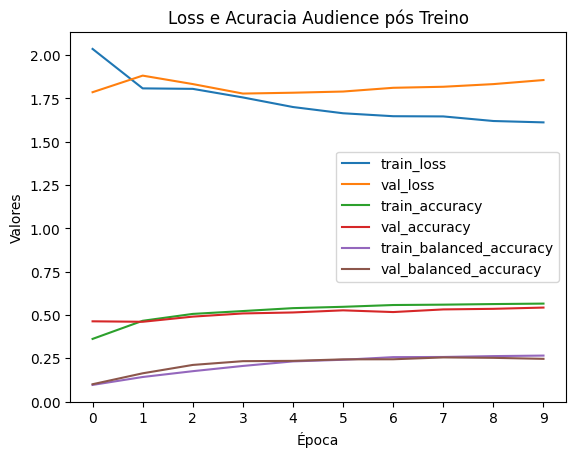

In [ ]:
model_audience_train_results.plot(kind='line')
plot.title('Loss e Acuracia Audience pós Treino')
plot.xticks(range(0, len(model_audience_train_results), 1))
plot.xlabel('Época')
plot.ylabel('Valores')
plot.legend(loc='best')
plot.show()

Evaluation of Training and Validation Results
1. General Observations
Training Loss and Accuracy:

Training loss decreases steadily from 2.04 (Epoch 1) to 1.61 (Epoch 10), showing consistent learning.
Training accuracy improves moderately from 36.2% to 56.5%, which is a positive but slow progression.
However, the training balanced accuracy remains low, starting at 9.6% and only improving to 26.5% by Epoch 10, indicating difficulties in handling class imbalance.
Validation Loss and Accuracy:

Validation loss fluctuates slightly but trends upward after Epoch 5, which may suggest overfitting starting around Epoch 6-7.
Validation accuracy improves modestly from 46.3% to 54.2% over the epochs, showing limited generalization improvement.
Validation balanced accuracy remains low throughout, starting at 10% and peaking at only 25.4% in Epoch 8 before declining slightly, indicating persistent issues with class imbalance in the validation set.
2. Key Observations by Epochs
Epochs 1-3:

Initial training and validation losses are high, with extremely poor balanced accuracies (below 20%). This suggests the model struggles to learn patterns for underrepresented classes in the early stages.
Validation accuracy is slightly better than training, which is common in early epochs as the model has not yet overfit to the training data.
Epochs 4-5:

Both training and validation metrics improve:
Training accuracy surpasses 50%.
Validation accuracy improves slightly but remains close to training.
Balanced accuracies improve but are still too low, highlighting the challenge of class imbalance.
Epochs 6-10:

Training loss continues to decrease, but validation loss stabilizes and begins increasing slightly, indicating potential overfitting.
Training and validation accuracies show diminishing returns in improvement.
Balanced accuracies show marginal gains and then stagnate, highlighting that the model continues to struggle with minority classes.
3. Key Concerns
Class Imbalance:

Despite improvements in accuracy, balanced accuracy remains low, reflecting poor performance in detecting minority classes.
The gap between accuracy and balanced accuracy suggests that the model is biased toward the majority classes.
Overfitting:

The validation loss increases after Epoch 6, while the training loss decreases, a clear sign of overfitting. This is reinforced by the stagnation in validation metrics after Epoch 5.
Generalization:

The modest improvement in validation accuracy (from 46.3% to 54.2%) indicates limited generalization. Despite improvements in training metrics, the validation metrics do not reflect significant learning progress.
4. Recommendations for Improvement
Addressing Class Imbalance:

Use class weighting during training to penalize misclassification of minority classes more heavily.
Apply oversampling (e.g., SMOTE) or undersampling to balance the dataset.
Consider data augmentation for minority classes.
Regularization:

Introduce regularization techniques such as dropout, weight decay, or early stopping to mitigate overfitting.
Hyperparameter Tuning:

Experiment with different learning rates, batch sizes, and model architectures to optimize training.
Use techniques like learning rate scheduling to improve convergence.
Model Architecture:

Explore more complex models or ensemble approaches to handle complex patterns in the data.
Alternatively, test simpler architectures if the dataset size is small.
Validation Strategy:

Ensure the validation set is representative of the training set to better evaluate model performance on imbalanced classes.
5. Final Remarks
While the model shows improvement in accuracy, the low balanced accuracy and signs of overfitting limit its real-world effectiveness. Addressing class imbalance and improving generalization should be prioritized to achieve meaningful improvements in model performance.

### Avaliação do Modelo no Conjunto Test

Modelo Critic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-29-0fc0a28404ea>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

Melhor modelo
Test Loss: 0.7999657513460459
Test Accuracy: 0.8469077391010477
Test Balanced Accuracy: 0.5988708861658044


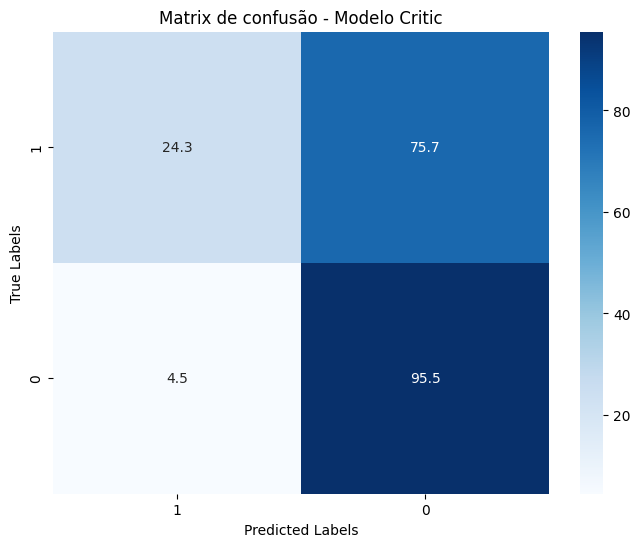

In [ ]:
best_epoch_critic = 6
model_config_critic = f'finetuned_CRITIC_{best_epoch_critic}.model'
best_model_critic = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC, output_attentions=True, output_hidden_states=False)
best_model_critic.load_state_dict(torch.load(model_config_critic, map_location=torch.device('cpu')))
best_model_critic.to(DEVICE)

print("Melhor modelo")
_, preds, labels = Test(best_model_critic, dataloader_test_critic, DEVICE)
print(f'Test Loss: {_}')
preds_array = numpy.argmax(preds, axis=1)
val_accuracy_2 = accuracy_score(labels, preds_array)
print(f'Test Accuracy: {val_accuracy_2}')
val_balanced_accuracy_2 = balanced_accuracy_score(labels, preds_array)
print(f'Test Balanced Accuracy: {val_balanced_accuracy_2}')

ConfusionMatrix(labels, preds_array, title="Matrix de confusão - Modelo Critic", classes_list=distinct_sentiment_labels)

Modelo Audience

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-38-9d53ba675903>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

Melhor modelo
Test Loss: 1.8080964450432697
Test Accuracy: 0.5065242273941244
Test Balanced Accuracy: 0.2327337254942452


<ipython-input-30-f637e50599c6>:3: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis] * 100


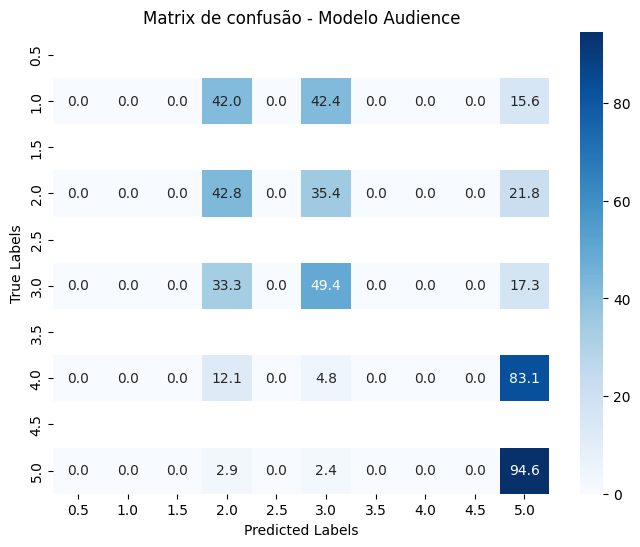

In [38]:
best_epoch_audience = 5
model_config_audience = f'finetuned_AUDIENCE_{best_epoch_audience}.model'
best_model_audience = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE, output_attentions=True, output_hidden_states=False)
best_model_audience.load_state_dict(torch.load(model_config_audience, map_location=torch.device('cpu')))
best_model_audience.to(DEVICE)

print("Melhor modelo")
_, preds, labels = Test(best_model_audience, dataloader_test_audience, DEVICE)
print(f'Test Loss: {_}')
preds_array = numpy.argmax(preds, axis=1)
val_accuracy_2 = accuracy_score(labels, preds_array)
print(f'Test Accuracy: {val_accuracy_2}')
val_balanced_accuracy_2 = balanced_accuracy_score(labels, preds_array)
print(f'Test Balanced Accuracy: {val_balanced_accuracy_2}')

distinct_rating_labels.sort()
ConfusionMatrix(labels, preds_array, title="Matrix de confusão - Modelo Audience", classes_list=distinct_rating_labels)

### Análise do Mecanismo de Atenção com BertViz



Modelo Critic

In [ ]:
input_ids=[]
for batch in dataloader_test_critic:
    input_ids.append(batch[0])

print(f'Modelo Critic')
correct_cases_critic = [(text, true, pred) for text, true, pred in zip(input_ids, labels_test_critic, preds_array) if true == pred]
print(f'Número de acertos: {len(correct_cases_critic)}')

decoded_correct_text_critic = TOKENIZER_CRITIC.decode(torch.tensor(correct_cases_critic[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso correto: {decoded_correct_text_critic}')

incorrect_cases_critic =[(text, true, pred) for text, true, pred in zip(input_ids, labels_test_critic, preds_array) if true != pred]
print(f'Número de incorretos: {len(incorrect_cases_critic)}')

decoded_incorrect_text_critic = TOKENIZER_CRITIC.decode(torch.tensor(incorrect_cases_critic[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso incorreto: {decoded_incorrect_text_critic}')

Modelo Critic
Número de acertos: 423
Texto caso correto: as expected, the production values are excellent, and the writing is solid, even cheeky at moments, and witty.
Número de incorretos: 2536
Texto caso incorreto: gaslit works because it isn't only about the watergate break - in - in the show, it occurs as early as in episode 2 - but also about the people whose lives and careers were made or unmade by the scandal.


In [ ]:
model = best_model_critic
print("Análise para um comentário que foi corretamente predito")
inputs = TOKENIZER_CRITIC.encode(decoded_correct_text_critic, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_CRITIC.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

print("Análise para um comentário que foi incorretamente predito")
inputs = TOKENIZER_CRITIC.encode(decoded_incorrect_text_critic, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_CRITIC.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

Análise para um comentário que foi corretamente predito


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Análise para um comentário que foi incorretamente predito


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelo Audience

In [ ]:
input_ids=[]
for batch in dataloader_test_audience:
    input_ids.append(batch[0])

print(f'Modelo Audience')
correct_cases_audience = [(text, true, pred) for text, true, pred in zip(input_ids, labels_test_audience, preds_array) if true == pred]
print(f'Número de acertos: {len(correct_cases_audience)}')

decoded_correct_text_audience = TOKENIZER_AUDIENCE.decode(torch.tensor(correct_cases_audience[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso correto: {decoded_correct_text_audience}')

incorrect_cases_audience =[(text, true, pred) for text, true, pred in zip(input_ids, labels_test_audience, preds_array) if true != pred]
print(f'Número de incorretos: {len(incorrect_cases_audience)}')

decoded_incorrect_text_audience = TOKENIZER_AUDIENCE.decode(torch.tensor(incorrect_cases_audience[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso incorreto: {decoded_incorrect_text_audience}')

Modelo Audience
Número de acertos: 6638
Texto caso correto: in my opinion this show eclipses the original star trek series and should be discussed as being one of the best tv shows of all time. now of course every episode isn't as great as others, but the series in itself leaves absolutely nothing to be desired. definitely the best science fiction tv show ever created!
Número de incorretos: 6467
Texto caso incorreto: surprisingly great drama with above average child acting and just enough cheese to not take itself too seriously.


In [ ]:
model = best_model_audience
print("Análise para um comentário que foi corretamente predito")
inputs = TOKENIZER_AUDIENCE.encode(decoded_correct_text_audience, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_AUDIENCE.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

print("Análise para um comentário que foi incorretamente predito")
inputs = TOKENIZER_AUDIENCE.encode(decoded_incorrect_text_audience, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_AUDIENCE.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

Análise para um comentário que foi corretamente predito


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Análise para um comentário que foi incorretamente predito


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>